# **Lab 4.2 NN MLP and CNN**

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from collections import Counter
from mpl_toolkits.axes_grid1 import ImageGrid


Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize(32)`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(45),`
- `transforms.CenterCrop(28)`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [49]:
def get_base_dataset(ds):
    # ไล่ลึก dataset จริง (ไม่ใช่ Subset)
    while hasattr(ds, 'dataset'):
        ds = ds.dataset
    return ds

def show_subset_detail(subset, data_name):
    base_ds = get_base_dataset(subset)

    # ดึง mapping class_to_idx (ถ้ามี)
    if hasattr(base_ds, 'class_to_idx'):
        class_map = base_ds.class_to_idx
    else:
        class_map = {}

    # ดึง labels ของ subset ตาม indices
    if hasattr(subset, 'indices') and hasattr(base_ds, 'targets'):
        targets = [base_ds.targets[i] for i in subset.indices]
    elif hasattr(base_ds, 'targets'):
        targets = base_ds.targets
    elif hasattr(base_ds, 'labels'):
        targets = base_ds.labels
    else:
        targets = []

    class_counts = Counter(targets)

    print(f"{data_name} Dataset:")
    for label in sorted(class_counts.keys()):
        print(f"\tNumber of images in class {label}: {class_counts[label]}")

    print(f"\tNumber of {data_name.lower()} samples: {len(subset)}")

In [50]:
def show_img(data_loader):
      
      images, labels = next(iter(data_loader))

      fig = plt.figure(figsize=(10, 10))
      plt.style.use('dark_background')

      grid = ImageGrid(fig, 111,
                        nrows_ncols=(4, 4),  
                        axes_pad=0.5,  
                        )

      for ax, im, lb in zip(grid, images, labels):
            im_np = im.permute(1, 2, 0).numpy()
            ax.axis('off')
            ax.set_title(str(lb.item()))
            ax.imshow(im_np, cmap='gray')

      plt.show()

In [98]:
def load_data(path,class_names):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Pad(20, padding_mode='edge'),
        transforms.Resize(32),
        transforms.RandomRotation(25, fill=255),
        transforms.CenterCrop(28),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    dataset = ImageFolder(root=path, transform=transform)

    class_to_idx = dataset.class_to_idx  
    selected_class_idxs = [class_to_idx[name] for name in class_names]

    indices = [i for i, (_, label) in enumerate(dataset) if label in selected_class_idxs]

    filtered_dataset = Subset(dataset, indices)     # สร้าง Subset ของ dataset เฉพาะ 2 คลาสนี้
    labels = [dataset.targets[i] for i in indices]  # ดึง label ของ subset สำหรับการแบ่ง train/test

    train_idx, test_idx = train_test_split(list(range(len(filtered_dataset))), test_size=0.2, stratify=labels, random_state=42) # แบ่ง train/test โดยใช้ sklearn

    train_dataset = Subset(filtered_dataset, train_idx)
    test_dataset = Subset(filtered_dataset, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

    show_subset_detail(train_dataset,"Train")
    show_subset_detail(test_dataset,"Test")
    show_img(train_loader)
    ### END CODE HERE ###
    
    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/03.png?raw=true)

</details>

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 311
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


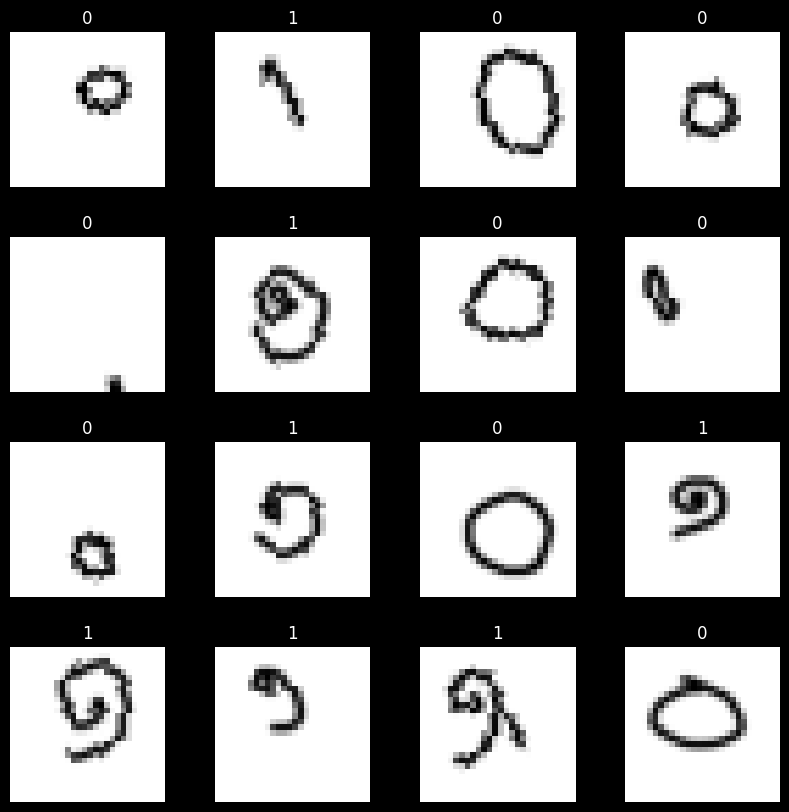

In [52]:
### START CODE HERE ###
class_names = [f'{x}' for x in range(2)]
train_loader, test_loader = load_data('thai-handwriting-number.appspot.com',class_names)

### END CODE HERE ###

**Create Models**
1. **NN (Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Single fully connected layer with sigmoid activation
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a simple feedforward neural network with a single fully connected layer. It takes input images, flattens them, passes through a fully connected layer, and applies sigmoid activation to produce the output.

2. **MLP (Multi-Layer Perceptron)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two fully connected layers with sigmoid activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a multi-layer perceptron with two fully connected layers. After flattening the input images, it passes through the first fully connected layer with sigmoid activation, followed by the second fully connected layer with sigmoid activation, producing the output.

3. **CNN (Convolutional Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two convolutional layers with ReLU activations, followed by two fully connected layers with ReLU activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


Every model should have a `get_features()` method that returns the result from all layers.

In [148]:
### START CODE HERE ###

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(28*28,1)
        self.sigmoid = nn.Sigmoid()

    def get_features(self, x):

        features = {}

        print(x.shape)
        features['ori'] = x.detach().cpu()

        x = self.flatten(x)
        print(x.shape)
        features['flatten'] = x.detach().cpu()
        
        x = self.fc(x)
        print(x.shape)
        features['fc'] = x.detach().cpu()
        print(f"FC values: min={x.detach().cpu().min():.3f}, max={x.detach().cpu().max():.3f}")

        x = self.sigmoid(x)
        print(x.shape)
        features['sigmoid'] = x.detach().cpu()
        print(f"sigmoid values: min={x.detach().cpu().min():.3f}, max={x.detach().cpu().max():.3f}")

        return features

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 48)      # ชั้นที่ 1
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(48, 1)            # ชั้นที่ 2 (output)
        self.sigmoid2 = nn.Sigmoid()
        
    def get_features(self, x):
        features = {}
        
        features['input'] = x.detach().cpu()
        
        x = self.flatten(x)
        features['flatten'] = x.detach().cpu()
        
        x = self.fc1(x)
        features['fc1'] = x.detach().cpu()
        
        x = self.sigmoid1(x)
        features['sigmoid1'] = x.detach().cpu()
        
        x = self.fc2(x)
        features['fc2'] = x.detach().cpu()
        
        x = self.sigmoid2(x)
        features['sigmoid2'] = x.detach().cpu()
        
        return features

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.sigmoid1(x)
        x = self.fc2(x)
        x = self.sigmoid2(x)
        return x
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # (1 input channel → 16 filters)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # (16 → 32 filters)

        self.pool = nn.MaxPool2d(2, 2)  # reduce spatial size

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Flattened after pooling
        self.fc2 = nn.Linear(128, 1)

        self.sigmoid = nn.Sigmoid()

    def get_features(self, x):
        features = {}

        features['input'] = x.detach().cpu()

        x = self.conv1(x)
        features['conv1'] = x.detach().cpu()
        x = F.relu(x)

        x = self.pool(x)
        features['pool1'] = x.detach().cpu()

        x = self.conv2(x)
        features['conv2'] = x.detach().cpu()
        x = F.relu(x)

        x = self.pool(x)
        features['pool2'] = x.detach().cpu()

        x = x.view(x.size(0), -1)  # Flatten
        features['flatten'] = x.detach().cpu()

        x = self.fc1(x)
        features['fc1'] = x.detach().cpu()
        x = F.relu(x)

        x = self.fc2(x)
        features['fc2'] = x.detach().cpu()

        x = self.sigmoid(x)
        features['output'] = x.detach().cpu()

        return features

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

### END CODE HERE ###

Complete the function below. This function will be used to display the feature map from the models at every epoch on TensorBoard.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical
- `NN()`<br>
![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/04.png?raw=true)
- `MLP()`<br>
![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/05.png?raw=true)
- `CNN()`<br>
![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/06.png?raw=true)
</details>

In [169]:
def show_featuremaps(features):
    ### START CODE HERE ###
    fig, axs = plt.subplots(1, len(features), figsize=(len(features)*3, 4))
    plt.style.use('dark_background')

    for ax, (name, feat) in zip(axs, features.items()):
        f = feat[0].cpu().numpy()  # ใช้ sample แรก
        print(f.ndim, f.shape[0])

        if f.ndim == 3:
            # รูปภาพต้นฉบับ (C, H, W)
            if f.shape[0] == 1:
                f = f[0]  # ถ้าเป็น grayscale
                ax.imshow(f)
            else:
                channels = []
                for i in range(f.shape[0]):  # วนลูป 16 channels
                    channels.append(f[i])  # เอาแต่ละ channel (28, 28)
                # ต่อกันแนวตั้ง (stack vertically)
                f_stacked = np.vstack(channels)  # (16*28, 28) = (448, 28)
                ax.imshow(f_stacked)

        elif f.ndim == 1:
            if f.shape[0] > 1:
                ax.imshow(f.reshape(-1, 1), aspect='auto')
            else:
                f_display = np.array([[f.item()]])
                ax.imshow(f_display, aspect='auto', vmin=0, vmax=1)

        ax.set_title(name)
        ax.axis('off')
    return fig

torch.Size([16, 1, 28, 28])
torch.Size([16, 784])
torch.Size([16, 1])
FC values: min=-0.303, max=0.031
torch.Size([16, 1])
sigmoid values: min=0.425, max=0.508
3 1
1 784
1 1
1 1


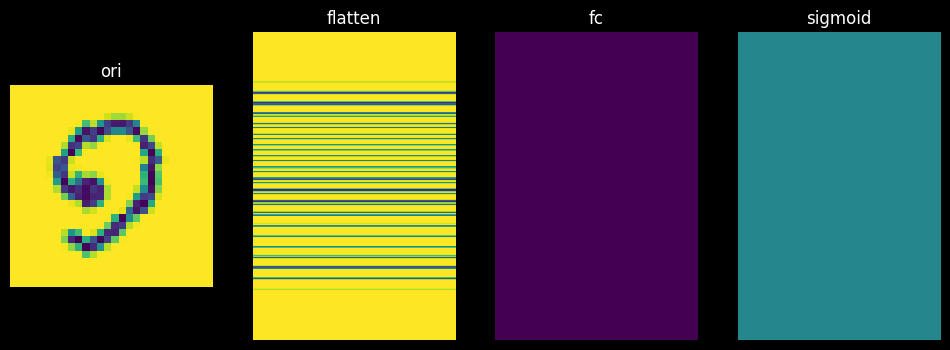

In [171]:
nn_model = NN()
data_iter = iter(train_loader)
input_tensor, _ = next(data_iter)
output= nn_model(input_tensor)
features = nn_model.get_features(input_tensor) 
fig = show_featuremaps(features)
plt.show() 

3 1
1 784
1 48
1 48
1 1
1 1


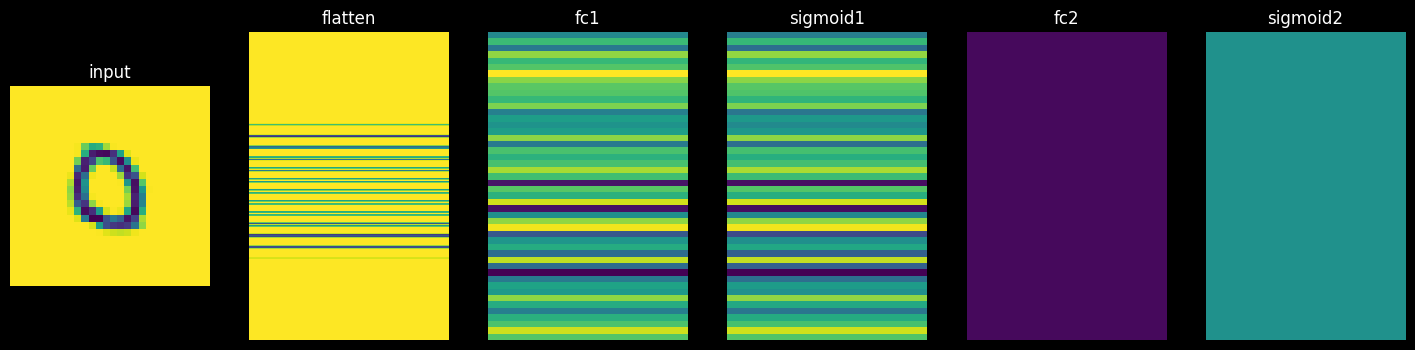

In [154]:
mlp_model = MLP()
data_iter = iter(train_loader)
input_tensor, _ = next(data_iter)
output= mlp_model(input_tensor)
features = mlp_model.get_features(input_tensor) 
fig = show_featuremaps(features)
plt.show() 

3 1
3 16
3 16
3 32
3 32
1 1568
1 128
1 1
1 1


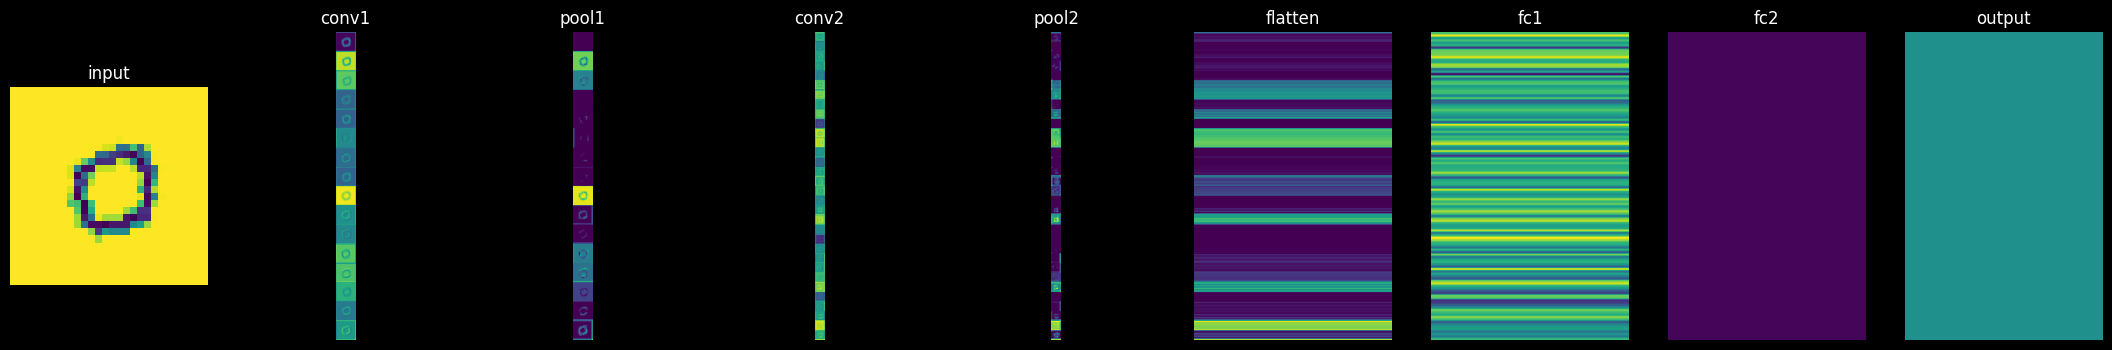

In [170]:
cnn_model = CNN()
data_iter = iter(train_loader)
input_tensor, _ = next(data_iter)
output= cnn_model(input_tensor)
features = cnn_model.get_features(input_tensor) 
fig = show_featuremaps(features)
plt.show() 

TensorBoard 101

Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy, and display the feature map from all layers of the model at every epoch on TensorBoard. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html)

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/07.png?raw=true)

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/08.png?raw=true)
</details>

In [58]:
def train(class_names,model,opt,loss_fn,train_loader,test_loader,epochs=10,writer=None,checkpoint_path=None,device='cpu'):
    ### START CODE HERE ###







    ### END CODE HERE ###

SyntaxError: incomplete input (1995350030.py, line 10)

Use your `train()` function to train all types of models with all combinations of numbers that you've obtained.

In [ ]:
### START CODE HERE ###



### END CODE HERE ###

Try to load the weights into the model and the confusion matrix for each model with every combination of numbers that you've obtained, as shown in the expected output.


<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
This is just an example of NN. You should have three models: NN, MLP, and CNN, with one model per plot.

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/09.png?raw=true)

</details>

In [ ]:
### START CODE HERE ###





### END CODE HERE ###

Questions
1. How does the performance of different models vary across different pairs of numbers in our dataset?
2. Can you identify the number pairs where the Neural Network model performs best and worst? Explain why the NN model is able/unable to classify these specific pairs based on the visualization of feature maps of each node in each layer.
3. Analyze and compare how MLP and CNN models perform on the dataset compared to the Neural Network model.  Identify scenarios where MLP and CNN outperform or underperform the NN. Explain the reasons behind these performance differences. Consider factors like the underlying structure of the data and the specific strengths of each model architecture.
4. According to your observations from questions 1-3, propose specific strategies to improve the performance of each model (NN, MLP, CNN) on this dataset. Consider factors such as data preprocessing, data augmentation, or potential changes to the model architecture itself. Justify your suggestions based on the strengths and limitations identified in the previous questions.
